In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

# Create data:
from qtn_sim import *

In [2]:
def getSparsity(statevector):
    return np.count_nonzero(statevector)/len(statevector)

def sparsityEstimator(tensors):

    if len(tensors) == 1:
        return np.count_nonzero(tensors[0].ravel())/len(tensors[0].ravel())
    
    tensorsLeft = tensors[:int(len(tensors)/2)]
    tensorsRight = tensors[int(len(tensors)/2):]
    
    return 1 - np.square(1-sparsityEstimator(tensorsLeft)*sparsityEstimator(tensorsRight))



In [3]:
numberOfQubits = 20
maxCircuitDepth = 200
numberOfCircuits = 2500
bd = 10
filePath = "circuits.json"

In [4]:
# Create data
circuitsCreated = createCircuits(numberOfCircuits=numberOfCircuits, 
                                 numberOfQubits=numberOfQubits, 
                                 maxCircuitDepth=maxCircuitDepth, 
                                 withNonAdjacent=False,
                                 filePath=filePath)



In [5]:
# Read the data
circuitsRead = readCircuits(filePath)

circuitsRead = [GHZCircuit(numberOfQubits), QFTCircuit(numberOfQubits)] + circuitsRead
print(len(circuitsRead))

2502


In [6]:
# GET THE DATA
sparsity = []
sparsityE = []
circuitEmbeddings = []

circuitIndex = 0

for circuit in circuitsRead:
    qSimulator = QuantumMPS(numberOfQubits,bd, SequentialOptimiser(swapping=True))
    qSimulator.applyCircuit(circuit)
    sparsity.append(getSparsity(qSimulator.get_state_vector()))
    e = sparsityEstimator(qSimulator.tensors)
    sparsityE.append(e)

In [7]:
# SAVE THE DATA
dims = int(100)

In [8]:
from circuitEmbedding import *
circuitEmbeddings = embedCircuits(circuitsRead, dims)
print(len(circuitEmbeddings))
pd.DataFrame(np.array(circuitEmbeddings)).to_csv("cEmbeddings.csv", index=False)

(2502, 512)
[0.17004002 0.26307652 0.29783488 0.32712746 0.35419587 0.3780044
 0.39934982 0.41820355 0.43557214 0.45135456 0.46663575 0.48082785
 0.49442156 0.50735182 0.51931704 0.53055983 0.54137535 0.55139858
 0.5611613  0.57032781 0.57908675 0.58749922 0.59573153 0.60359282
 0.61110385 0.61832095 0.62521902 0.63194011 0.63842642 0.64469506
 0.65078039 0.65647626 0.66207335 0.667449   0.67260477 0.67762643
 0.68255966 0.68742628 0.69225555 0.69691713 0.70146749 0.7058069
 0.71009545 0.7142631  0.71840748 0.72248666 0.72634452 0.73017434
 0.73398066 0.73769551 0.74133928 0.74493199 0.74845831 0.7519026
 0.75527479 0.75857831 0.76181297 0.7649748  0.76812267 0.77125154
 0.77429937 0.7773198  0.78026371 0.78318409 0.7860676  0.78892516
 0.79170649 0.79445621 0.79710186 0.79971885 0.8023053  0.80482452
 0.80731958 0.80977935 0.81222135 0.81464146 0.81703389 0.81941036
 0.82170246 0.82397219 0.82618033 0.8283645  0.83051794 0.83262382
 0.83469404 0.83674601 0.83877203 0.84078583 0.842758

In [9]:

data = [circuitEmbeddings[i].tolist() + [sparsity[i], sparsityE[i]] for i in range(len(circuitEmbeddings))]

data = pd.DataFrame(np.array(data))

data.to_csv('sparsity.csv', index=False)

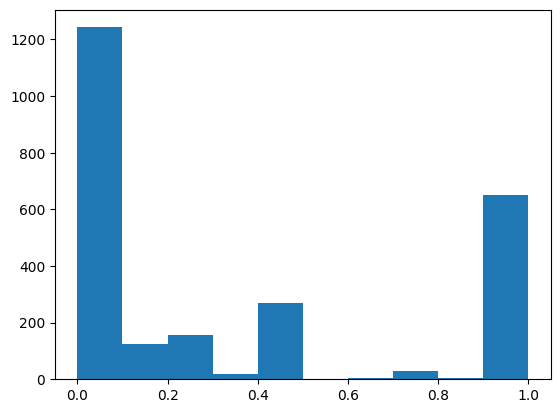

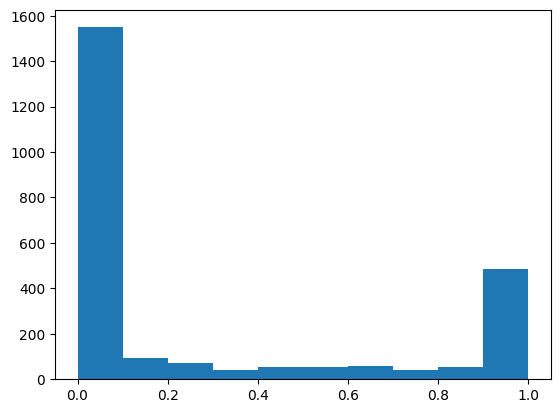

In [10]:
# LOAD THE DATA
data = pd.read_csv('sparsity.csv')

# Data distribution

plt.hist(data[str(dims)])
plt.show()
plt.hist(data[str(dims+1)])
plt.show()

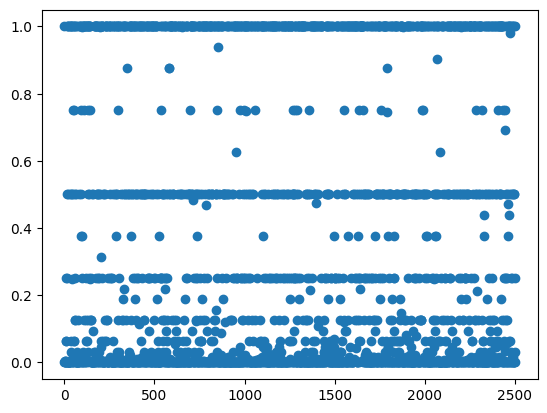

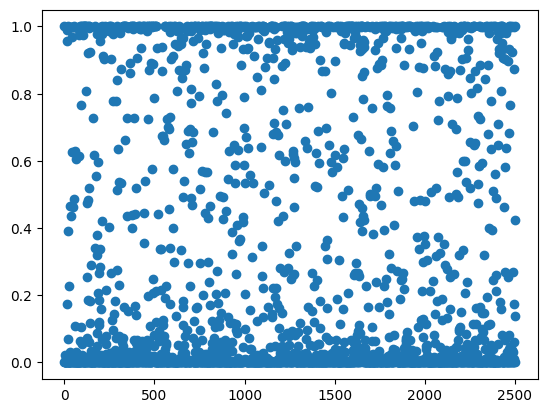

In [11]:
x = [i for i in range(numberOfCircuits+2)]
plt.scatter(x,data[str(dims)])
plt.show()
plt.scatter(x,data[str(dims+1)])
plt.show()

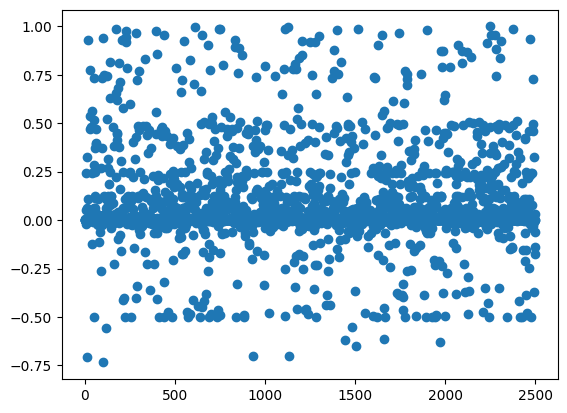

In [12]:
diff = data[str(dims)] - data[str(dims+1)]


plt.scatter([i for i in range(numberOfCircuits+2)],diff)
plt.show()

Average + difference.
Sparse circuits actual & est.
Different levels of sparsity performance est. Diff over regions.



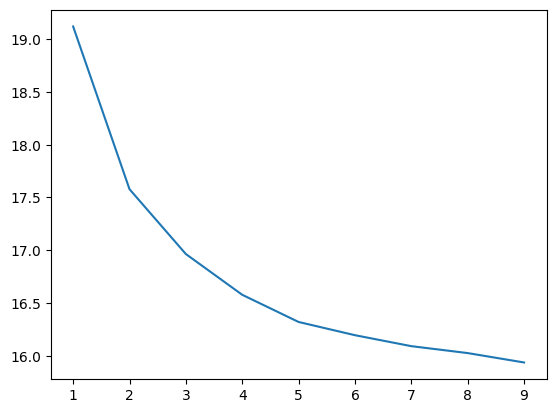

In [13]:
# Choose 3 bins for the sparsity, so 3 clusters

# Clustering
X = data[:-2]

# Xs = (X - np.mean(X,axis = 0))/np.std(X, axis = 0)
Xs = X
inertia = []
K = 10
distortions = [] 
for k in range(1,K):
    km = KMeans(n_clusters=k, max_iter=10000)
    km = km.fit(Xs)
    inertia.append(km.inertia_)
    distortions.append(sum(np.min(cdist(X,km.cluster_centers_, 'euclidean'),axis=1))/Xs.shape[0])

plt.plot([i for i in range(1,K)], distortions)
plt.show()


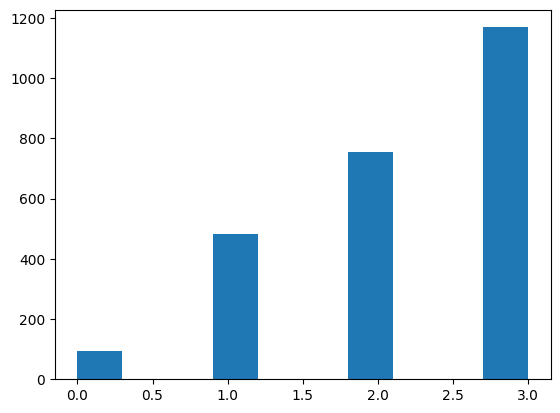

In [14]:
k = 4

km = KMeans(n_clusters=k, max_iter=10000)
# km = km.fit(X)

# label = km.fit_predict(data[:-1])

# plt.hist(label)

original_labels = km.fit_predict(X)

from collections import Counter
# Count the number of data points in each cluster
cluster_sizes = Counter(original_labels)

# Create a mapping from original labels to new labels
# sorted by cluster size in ascending order
label_mapping = {old_label: new_label for new_label, (old_label, _) 
                 in enumerate(sorted(cluster_sizes.items(), key=lambda x: x[1]))}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in original_labels])


plt.hist(new_labels)

plt.show()



Gate occurence: Notes.

Sparsity evolution through circuit application.

Bert embedding: space semantically significant?